In [1]:
%load_ext autoreload
%autoreload 2

# python
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("ATLAS")
import pandas as pd
import sys
sys.path.append("../")

# custom
import Utils as ut
from Utils import loadALEPH2004Result, loadWeights, ensembleWeights, calc_hist, plotThrust
import dataloader

aleph = ut.loadALEPH2004Result()

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -


/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:114: RuntimeWarning: divide by zero encountered in log
  aleph_log_bins = np.log(aleph_bins)


In [2]:
aleph = ut.loadALEPH2004Result()
print(aleph["aleph_log_thrust_errs"])
print(aleph["aleph_log_thrust_errs"] - np.linalg.norm(aleph["aleph_log_thrust_errs_individual"], axis=1))

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -
[0.00059364 0.00761793 0.01701719 0.00781693 0.00746136 0.00677942
 0.00814534 0.0077546  0.0070463  0.00968856 0.00883575 0.00875478
 0.00948643 0.00881046 0.00790756 0.00968362 0.00909576 0.0086974
 0.0068823  0.00685199 0.00751772 0.00534918 0.00509836 0.00535912
 0.00636601 0.00561443 0.00563602 0.00609543 0.00640759 0.00483177
 0.00531451 0.00450477 0.00354568 0.00293204 0.00207306 0.00221681
 0.00172053 0.00111097 0.00080795 0.00057632 0.00050214 0.00029193]
[ 0.00000000e+00  0.00000000e+00  3.46944695e-18  0.00000000e+00
 -8.67361738e-19  0.00000000e+00  1.73472348e-18 -8.67361738e-19
 -8.67361738e-19  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.73472348e-18
  1.73472348e-18 -1.73472348e-18  0.00000000e+00  8.67361738e-19
 -8.67361738e-19  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.000000

In [3]:
# Load the data
import json
with open("../training_conf.json") as f:
      training_conf = json.load(f)
reco_data, reco_mc, gen_mc, pass_reco, pass_gen = dataloader.DataLoader(training_conf)
# flatten
reco_data = reco_data.flatten()
reco_mc = reco_mc.flatten()
gen_mc = gen_mc.flatten()
print(reco_data.shape, reco_mc.shape, gen_mc.shape, pass_reco.shape, pass_gen.shape)
# apply selection
reco_mc = reco_mc[pass_reco]
gen_mc = gen_mc[pass_gen] # fully efficient
print(reco_mc.shape, gen_mc.shape)

(1365440,) 1326338
(771597,) 751853
(1326338,) (973769,) (973769,) (973769,) (973769,)
(751853,) (973769,)


In [4]:
N = 10

# # analysis note review 1 results
# ensemble = "/global/homes/b/badea/aleph/unfold-ee-logtau/results/training-745de56e/*/model_weights*" # Nominal result
# # ensemble = "/global/homes/b/badea/aleph/unfold-ee-logtau/results/training-d6b08785/*/model_weights*" # gen cleaning
# ensemble_weights = ensembleWeights(loadWeights(ensemble), N=N)
# print(ensemble_weights.shape)

# systematic = "/global/homes/b/badea/aleph/unfold-ee-logtau/results/training-439c81ff/*/model_weights*"
# systematic_weights = ensembleWeights(loadWeights(systematic), N=N)
# print(systematic_weights.shape)

# theory = "/global/u1/b/badea/aleph/unfold-ee-logtau/results/training-65d965a4/*/model_weights*"
# theory_weights = ensembleWeights(loadWeights(theory), N=N)
# print(theory_weights.shape)

# # analysis note review 2 results
filePath = "/pscratch/sd/b/badea/aleph/unfold-ee-logtau/UniFold/results/training-e583e610/*/*/conf.json"
w = ut.loadWeightPaths(filePath)
for key, val in w.items():
    for k, v in val.items():
        w[key][k] = ensembleWeights(loadWeights(v), N=N)
        print(key, k, w[key][k].shape)

# make keys
ensemble_weights = w["Ensembling"]["nominal"]
systematic_weights_order = ['ntpc7', 'pt04', 'ech10', 'no_neutrals', 'with_met']
systematic_weights = np.concatenate([w["Systematics"][k] for k in systematic_weights_order], axis=0)
theory_weights = w["TheoryUncertainty_Sherpa"]["nominal"]
print(ensemble_weights.shape)
print(systematic_weights_order, systematic_weights.shape)
print(theory_weights.shape)

Systematics no_neutrals (1, 1, 973769)
Systematics with_met (1, 1, 973769)
Systematics pt04 (1, 1, 973769)
Systematics ntpc7 (1, 1, 973769)
Systematics ech10 (1, 1, 973769)
Ensembling nominal (1, 10, 973769)
TheoryUncertainty_Sherpa nominal (1, 1, 973769)
(1, 10, 973769)
['ntpc7', 'pt04', 'ech10', 'no_neutrals', 'with_met'] (5, 1, 973769)
(1, 1, 973769)


In [5]:
# plotting configuration
conf = {
    "logtau" : {
        "aleph" : {
            "x" : aleph["aleph_log_midbins"], 
            "y": aleph["aleph_log_thrust"], 
            "xerr": aleph["aleph_log_binwidths"]/2, 
            "yerr": aleph["aleph_log_thrust_errs"], 
            "bins" : aleph["aleph_log_bins"]
        },
        "ax1_ylabel" : r"1/$\sigma$ d$\sigma$/dlog(1-T)",
        "ax1_yscale" : "log",
        "ax2_xscale" : "linear",
        "ax1_ylim" : [0.2*10**-5, 10**0],
        "ax2_xlabel" : r"$\log(\tau)$", # "log(1-T)",
        "ax2_ylim" : [0.01, 1.99],
        "bins" : np.linspace(aleph["log_bins_min"], np.log(0.5), 51),
        "legend" : "lower right",
        "legend_bbox" : (0.98, 0.0)
    },
    # "thrust" : {
    #     "aleph" : {
    #         "x" : aleph["aleph_midbins"], 
    #         "y": aleph["aleph_thrust"], 
    #         "xerr": aleph["aleph_binwidths"]/2, 
    #         "yerr": aleph["aleph_thrust_errs"], 
    #         "bins" : aleph["aleph_bins"]
    #     },
    #     "ax1_ylabel" : r"1/$\sigma$ d$\sigma$/d(1-T)",
    #     "ax1_yscale" : "log",
    #     "ax2_xscale" : "linear",
    #     "ax1_ylim" : [0.3*10**-3, 4*10**1],
    #     "ax2_xlabel" : "1-T",
    #     "ax2_ylim" : [0.68, 1.32],
    #     "bins" : np.linspace(0, 0.45, 51),
    #     "legend" : "lower left",
    #     "legend_bbox" : (0.05, 0.0)
    # }
}    

In [6]:
# make histograms
plots = {}
for key, val in conf.items():
    plots[key] = {}
    for binType in ["nominal", "aleph"]:
        bins = val["bins"] if binType == "nominal" else val["aleph"]["bins"]
        # data histograms
        plots[key][f"data_{binType}"] = calc_hist(reco_data, bins=bins, density=True) # = counts_data, errors_data, bin_edges
        # mc reco histograms
        plots[key][f"mc_reco_{binType}"] = calc_hist(reco_mc, bins=bins, density=True)
        # gen before histograms
        plots[key][f"mc_genBefore_{binType}"] = calc_hist(gen_mc, bins=bins, density=True)
        # unifold histograms
        for iW, weights in enumerate(np.squeeze(ensemble_weights, axis=0)):
            plots[key][f"unifold_{binType}_ensemble{iW}"] = calc_hist(gen_mc, bins=bins, density=True, weights=weights.flatten())
        for iW, weights in enumerate(systematic_weights):
            plots[key][f"unifold_{binType}_systematic{iW}"] = calc_hist(gen_mc, bins=bins, density=True, weights=weights.flatten())
        for iW, weights in enumerate(theory_weights):
            plots[key][f"unifold_{binType}_theory{iW}"] = calc_hist(gen_mc, bins=bins, density=True, weights=weights.flatten())

(50,)
(50,)
Error shapes:  (50, 8)


/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:172: RuntimeWarning: invalid value encountered in divide
  ratio = A / B
/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:179: RuntimeWarning: invalid value encountered in divide
  (A_err / A)**2 + (B_err / B)**2


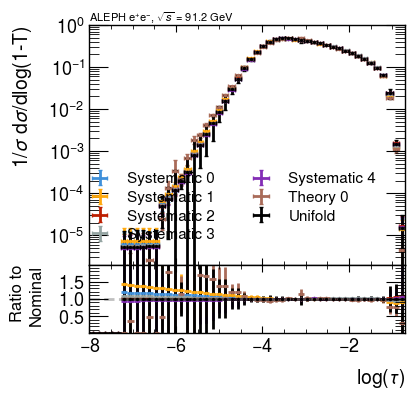

(42,)
(42,)
Error shapes:  (42, 8)


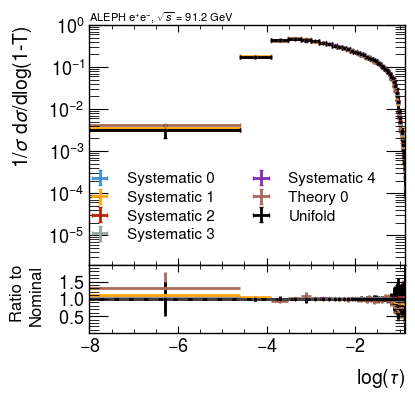

In [7]:
errors = {}
for key, val in conf.items():
    errors[key] = {}
    for binType in ["nominal", "aleph"]:
        
        # bins
        bins = val["bins"] if binType == "nominal" else val["aleph"]["bins"]
        binwidths = bins[1:] - bins[:-1]
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # style
        style = {
            "legend_loc" : val["legend"],
            "legend_bbox" : val["legend_bbox"],
            "legend_ncol" : 2,
            "legend_fontsize" : 11,
            "ax1_ylabel" : val["ax1_ylabel"],
            "ax1_yscale" : val["ax1_yscale"],
            "ax2_xlabel" : val["ax2_xlabel"],
            "ax2_xscale" : val["ax2_xscale"],
            "ax2_ylabel" : f'Ratio to\nNominal',
            "ax1_ylim" : val["ax1_ylim"],
            "bins" : bins,
            "ax2_ylim" : val["ax2_ylim"],
        }

        # pick up nominal
        nominal = plots[key][f"unifold_{binType}_ensemble0"]

        # inPlots
        inPlots = {}
        systList = [
            # ["ensemble", 0], #ensemble_weights.shape[1]],
            ["systematic", systematic_weights.shape[0]],
            ["theory", theory_weights.shape[0]]
        ]
        # define list for all errors
        # err = []

        # define lists for systematic errors and theory errors
        systematic_err = []
        theory_err = []
        for systType, iWRange in systList:
            for iW in range(iWRange):
                inPlots[f"unifold_{binType}_{systType}{iW}"] = {
                    "plotType": "errorbar", 
                    "x": bin_centers, 
                    "y": plots[key][f"unifold_{binType}_{systType}{iW}"][0], 
                    "color": None, 
                    "label": f"{systType.title()} {iW}", 
                    "xerr": binwidths/2, 
                    "yerr": plots[key][f"unifold_{binType}_{systType}{iW}"][1]
                }
                if systType == "systematic":
                    systematic_err.append(nominal[0] - plots[key][f"unifold_{binType}_{systType}{iW}"][0])
                if systType == "theory":
                    theory_err.append(nominal[0] - plots[key][f"unifold_{binType}_{systType}{iW}"][0])
        
        # compute totals
        total_exp_systematic_err = np.sqrt(np.sum(np.stack(systematic_err,axis=1)**2, axis=1)) # take the sum in quadrature
        print(total_exp_systematic_err.shape)
        total_theory_err = np.sqrt(np.sum(np.stack(theory_err,axis=1)**2, axis=1)) # take the sum in quadrature
        print(total_exp_systematic_err.shape)

        # append to errors
        # err += systematic_err
        # err += theory_err

        # inPlots["unifold"] = {"plotType": "errorbar", "x": bin_centers, "y": nominal[0], "color": "red", "label": "Unifold", "xerr":binwidths/2, "yerr":nominal[1]}
        
        # get the ensemble uncertainty
        ensemble_err = []
        for iW in range(1, ensemble_weights.shape[1]): # don't include the nominal setting
            ensemble_err.append(plots[key][f"unifold_{binType}_ensemble{iW}"][0])
        ensemble_err = np.array(ensemble_err)
        total_ensemble_err = np.std(ensemble_err, axis=0) # take std over the errors
        if total_ensemble_err.shape != nominal[1].shape:
            print(f"Total ensemble error was: {total_ensemble_err}. So setting the total ensemble error to zero")
            total_ensemble_err = np.zeros(nominal[1].shape)
        # append to errors
        # err.append(list(total_ensemble_err))
        
        # build the full uncertainty
        err = [list(nominal[1])] + systematic_err + theory_err + [list(total_ensemble_err)]
        # err.insert(0, list(nominal[1])) # prepend the stat uncertainty
        err = np.stack(err, axis=1) 
        total_err = np.sqrt(np.sum(err**2, axis=1)) # add errors in quadrature
        print("Error shapes: ", err.shape)

        # create entry for the errors
        errors[key][f"unifold_{binType}_ensemble0"] = {
            "total" : total_err, 
            "individual" : err,
            "nominal_stat_uncertainty" : nominal[1],
            "total_exp_systematic_error" : total_exp_systematic_err,
            "total_theory_error" : total_theory_err,
            "total_ensemble_error" : total_ensemble_err,
        }

        # plot
        inPlots["unifold"] = {"plotType": "errorbar", "x": bin_centers, "y": nominal[0], "color": "black", "label": "Unifold", "xerr":binwidths/2, "yerr":total_err}
        
        # ratio denominator using the total error
        ratio_denom = [[nominal[0], total_err, nominal[2]]]

        fig, (ax1, ax2) = plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10)
        plt.show()
        plt.close()

In [8]:
# check the uncertainty components statistical, experimental systematic, theoretical systematic versus the aleph publication
unifoldForComparison = np.stack([
    errors['logtau'][f'unifold_aleph_ensemble0']['total'], # total
    errors['logtau'][f'unifold_aleph_ensemble0']['nominal_stat_uncertainty'], # statistical
    errors['logtau'][f'unifold_aleph_ensemble0']['total_exp_systematic_error'], # experimental systematic
    errors['logtau'][f'unifold_aleph_ensemble0']['total_theory_error'], # theoretical systematic
], axis=1)
alephForComparison = np.concatenate([
    aleph["aleph_log_thrust_errs"].reshape(-1, 1), # total
    aleph["aleph_log_thrust_errs_individual"][:, 0].reshape(-1, 1), # statistical
    aleph["aleph_log_thrust_errs_individual"][:, 1].reshape(-1, 1), # experimental systematic
    aleph["aleph_log_thrust_errs_individual"][:, 2].reshape(-1, 1), # experimental systematic
], axis=1)
ratio = unifoldForComparison/alephForComparison
# print(ratio)
table = np.concatenate([aleph["aleph_log_midbins"].reshape(-1, 1), ratio], axis=1)

# Convert the table to a pandas DataFrame for better formatting
# Define column names
columns = ["Bin Center", "Ratio Total Error", "Ratio Statistical", "Ratio Experimental Syst.", "Ratio Theory Syst."]
# Create a DataFrame
df = pd.DataFrame(table, columns=columns)
# Print the DataFrame as a table
print(df.to_string(index=False, float_format="{:.6f}".format))


 Bin Center  Ratio Total Error  Ratio Statistical  Ratio Experimental Syst.  Ratio Theory Syst.
  -6.302585           1.876619           1.021306                  0.738333            7.239542
  -4.258597           1.127905           0.897738                  2.562255            0.186447
  -3.709290           1.561147           0.880678                  4.747793            1.460895
  -3.362717           1.542757           0.929621                  4.113633            0.712605
  -3.107304           4.995365           0.947956                  2.424629            5.529690
  -2.904571           2.007867           0.952323                  2.543023            1.959295
  -2.736335           0.819322           0.956573                  2.391907            0.387119
  -2.592494           0.835358           0.937417                  1.818671            0.557107
  -2.466837           0.759836           0.952752                  2.496701            0.122645
  -2.355265           0.820120          

No ratio plot for aleph


/tmp/ipykernel_1548579/3299774432.py:35: RuntimeWarning: invalid value encountered in divide
  inPlots["total"] = {"plotType": "stairs", "x": bins, "y": total_err / nominal[0], "color": None, "label": "Unifold Total Error", "ls":"-"}
/tmp/ipykernel_1548579/3299774432.py:40: RuntimeWarning: invalid value encountered in divide
  inPlots[f"component_{i}"] =  {"plotType": "stairs", "x": bins, "y": individual[:,i] / nominal[0], "color": colors[i], "label": labels[i], "ls": "-"} # f"Component {i}"
/tmp/ipykernel_1548579/3299774432.py:42: RuntimeWarning: invalid value encountered in divide
  ratio_denom = [[total_err/nominal[0]], [errors[key][f"unifold_aleph_ensemble0"]["total"] / plots[key][f"unifold_aleph_ensemble0"][0]]]


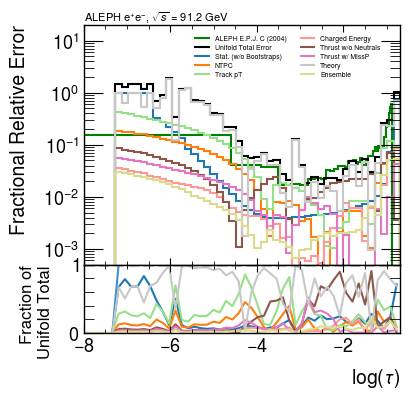

No ratio plot for aleph


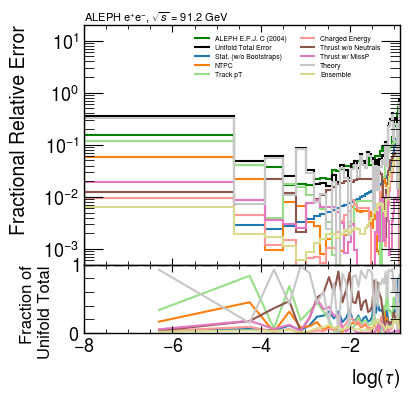

In [9]:
for key, val in conf.items():
    for binType in ["nominal", "aleph"]:
        
        # bins
        bins = val["bins"] if binType == "nominal" else val["aleph"]["bins"]
        binwidths = bins[1:] - bins[:-1]
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # style
        style = {
            "legend_loc" : "upper left",
            "legend_bbox" : (0.32, 1.0),
            "legend_ncol" : 2,
            "legend_fontsize" : 5,
            "ax1_ylabel" : "Fractional Relative Error",
            "ax1_yscale" : val["ax1_yscale"],
            "ax2_xlabel" : val["ax2_xlabel"],
            "ax2_xscale" : val["ax2_xscale"],
            "ax2_ylabel" : f'Fraction of\nUnifold Total',
            "ax1_ylim" : [5*10**-4, 2*10**1], #[0.5*10**-6, 5*10**-1],
            "bins" : bins,
            "ax2_ylim" : [0,1],
        }
        
        # nominal
        nominal = plots[key][f"unifold_{binType}_ensemble0"]

        # pick up the errors
        total_err = errors[key][f"unifold_{binType}_ensemble0"]["total"]
        individual = np.abs(errors[key][f"unifold_{binType}_ensemble0"]["individual"])
        
        # inPlots
        inPlots = {}
        inPlots["aleph"] = {"plotType": "stairs", "x": val["aleph"]["bins"], "y": val["aleph"]["yerr"] / val["aleph"]["y"], "color": "green", "label": 'ALEPH E.P.J. C (2004)', "ls":"-", "noratio":True}
        inPlots["total"] = {"plotType": "stairs", "x": bins, "y": total_err / nominal[0], "color": None, "label": "Unifold Total Error", "ls":"-"}
        # other variations
        colors = [plt.cm.tab20(i / individual.shape[1]) for i in range(individual.shape[1])]
        labels = ["Stat. (w/o Bootstraps)", "NTPC", "Track pT", "Charged Energy", "Thrust w/o Neutrals", "Thrust w/ MissP", "Theory", "Ensemble"]
        for i in range(individual.shape[1]):
            inPlots[f"component_{i}"] =  {"plotType": "stairs", "x": bins, "y": individual[:,i] / nominal[0], "color": colors[i], "label": labels[i], "ls": "-"} # f"Component {i}"
        # ratio denominator using the total error
        ratio_denom = [[total_err/nominal[0]], [errors[key][f"unifold_aleph_ensemble0"]["total"] / plots[key][f"unifold_aleph_ensemble0"][0]]]

        fig, (ax1, ax2) = plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10)
        plt.savefig(f"{key}_unifold_binning_{binType}_uncertaintyBreakdown.pdf", bbox_inches='tight')
        plt.show()
        plt.close()

[0.82367927 0.93560219 0.96865584 1.00207608 1.01623756 1.02357168
 1.03061443 1.03135257 1.03346418 1.04255686 1.02979727 1.03085574
 1.01189775 1.0405503  1.03576022 1.01500133 1.04473376 1.0254541
 1.03973122 1.03413453 1.06329222 1.0638581  1.04225662 1.06990865
 1.02722479 1.07716155 0.98752603 1.05360243 1.08015218 1.08166816
 1.05907329 1.0424764  1.10823377 1.05054059 1.08713225 0.96652604
 1.06379867 1.00558039 0.839601   1.01183582 0.79219922 0.8055369 ]



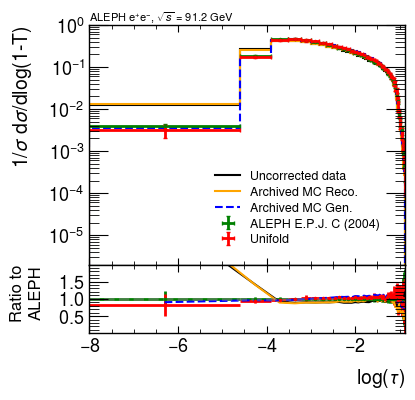

/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:172: RuntimeWarning: invalid value encountered in divide
  ratio = A / B
/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:179: RuntimeWarning: invalid value encountered in divide
  (A_err / A)**2 + (B_err / B)**2


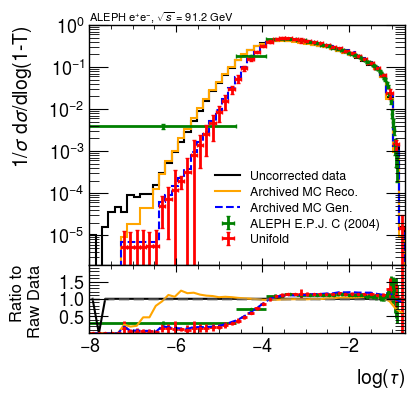

/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:172: RuntimeWarning: invalid value encountered in divide
  ratio = A / B
/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:179: RuntimeWarning: invalid value encountered in divide
  (A_err / A)**2 + (B_err / B)**2
/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:172: RuntimeWarning: divide by zero encountered in divide
  ratio = A / B


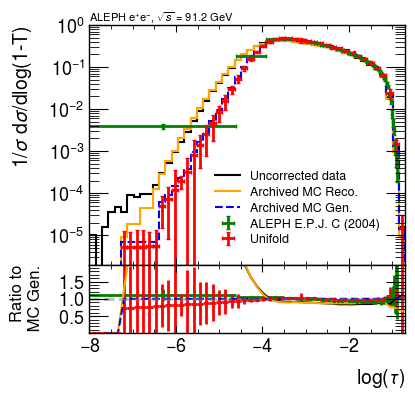

In [11]:
for key, val in conf.items():
    for ratioTo in ["aleph", "data", "genBefore"]:

        # bins
        binType = "aleph" if ratioTo == "aleph" else "nominal"
        bins = val["aleph"]["bins"] if ratioTo == "aleph" else val["bins"]
        binwidths = bins[1:] - bins[:-1]
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # define denominator for ratio
        if ratioTo == "aleph":
            ratio_denom = [val["aleph"]["y"], val["aleph"]["yerr"]]
            ratio_denom = [ratio_denom] # expect list of lists
            ax2_ylabel = f'Ratio to\nALEPH'
            print(plots[key][f"unifold_{binType}_ensemble0"][0]/val["aleph"]["y"])
            print()
        elif ratioTo == "data":
            ratio_denom = [plots[key][f"data_{binType}"], plots[key][f"data_aleph"]]
            ax2_ylabel = f'Ratio to\nRaw Data'
        elif ratioTo == "genBefore":
            ratio_denom = [plots[key][f"mc_genBefore_{binType}"], plots[key][f"mc_genBefore_aleph"]]
            ax2_ylabel = f'Ratio to\n MC Gen.'
        else:
            print("nothing")
        
        # style
        style = {
            "legend_loc" : val["legend"],
            "legend_bbox" : val["legend_bbox"],
            "legend_ncol" : 1,
            "legend_fontsize" : 9,
            "ax1_ylabel" : val["ax1_ylabel"],
            "ax1_yscale" : val["ax1_yscale"],
            "ax2_xlabel" : val["ax2_xlabel"],
            "ax2_xscale" : val["ax2_xscale"],
            "ax2_ylabel" : ax2_ylabel,
            "ax1_ylim" : val["ax1_ylim"],
            "bins" : bins,
            "ax2_ylim" : val["ax2_ylim"],
        }

        # inPlots
        inPlots = {}
        inPlots["aleph"] = {"plotType": "errorbar", "x": val["aleph"]["x"], "y": val["aleph"]["y"], "color": "green", "label": 'ALEPH E.P.J. C (2004)', "xerr":val["aleph"]["xerr"], "yerr":val["aleph"]["yerr"]}
        inPlots["unifold"] = {"plotType": "errorbar", "x": bin_centers, "y": plots[key][f"unifold_{binType}_ensemble0"][0], "color": "red", "label": "Unifold", "xerr":binwidths/2, "yerr":errors[key][f"unifold_{binType}_ensemble0"]["total"]}
        inPlots["data"] = {"plotType": "stairs", "x": bins, "y": plots[key][f"data_{binType}"][0], "color": "black", "label": "Uncorrected data", "ls":"-"}
        inPlots["mc_reco"] = {"plotType": "stairs", "x": bins, "y": plots[key][f"mc_reco_{binType}"][0], "color": "orange", "label": "Archived MC Reco.", "ls":"-"}
        inPlots["mc_genBefore"] = {"plotType": "stairs", "x": bins, "y": plots[key][f"mc_genBefore_{binType}"][0], "color": "blue", "label": "Archived MC Gen.", "ls":"--"}
        
        fig, (ax1, ax2) = plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10)
        plt.savefig(f"{key}_unifold_ratioTo_{ratioTo}.pdf", bbox_inches='tight')
        plt.show()
        plt.close()
        

